In [2]:
import scipy.stats as st
from statsmodels.formula.api import ols, rlm
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabulate as tb
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
%matplotlib inline

# Caso 1.1.
## Estimación de una función de demanda de dinero con datos de la economía española.

En el fichero DEMDIN.GDT se ofrece información de la economía española en el periodo 1964-1985 de las siguientes variables:

- M1: Efectivo en manos del público + depósitos a la vista

- ipc: índice de precios al consumo base 1970

- rc: tipo de interés a corto plazo (tipo de los depósitos a menos de un año)

- rl: tipo de interés a largo plazo (rendimiento interno de las obligaciones privadas)

- y: PIB en unidades monetarias constantes de 1970.


>Alternativamente, los datos de M1, producción a precios
constantes y tipo de interés a corto y largo plazo, todos ellos para Europa, se
pueden obtener de la base de datos del Banco de España que se ofrece a través
del propio Gretl en la opción Archivos-Bases de datos-Sobre servidor. El dato
del IPC con base 2005 se puede obtener de la base de datos del BCE en internet.
Se pueden usar todos los datos mensuales y cuando se cargan desde Gretl se
puede decir que convierta los datos trimestrales en mensuales interpolando. Los
datos del IPC habrá que guardarlos en formato Excel y después añadirlos a los
que tengamos en Gretl, teniendo cuidado de que los decimales estén en Excel con
coma y que coincidan los periodos inicial y final.

# Se plantea estimar la siguiente función de demanda de dinero:

$$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

En el modelo se intenta explicar la demanda de dinero en función de la renta real, utilizándose el PIB, para estimar el efecto del motivo transacción. La segunda variable explicativa, el tipo de interés, recoge el comportamiento de la demanda de dinero especulativo, representando el coste de oportunidad de mantener dinero como forma de ahorro. La última variable, el índice de precios al consumo, se introduce como variable explicativa para valorar el efecto de la inflación sobre la demanda nominal de dinero.

- a)  Estimar el modelo de oferta monetaria, utilizando el tipo de interés a corto plazo para los grupos tipo A y el tipo a largo para los grupos tipo B. Comentar los resultados desde el punto de vista económico y econométrico.

- b)  Contrastar la restricción $β_3 = 1$, comentando sus implicaciones económicas. Hacer los cálculos paso a paso sin usar las opciones directas de Gretl.

- c)  Estimar el modelo asumiendo que la restricción es cierta.

- d)  Suponer que queremos estimar el modelo usando la variable M1 en términos reales, imponiendo para ello la restricción del apartado b), y a la vez seguir manteniendo el ipc como variable explicativa. Pensar cómo transformar el modelo para conseguir el doble objetivo anterior y calcular de forma razonada (con la ayuda de la estimación del apartado a) el valor del coeficiente que acompaña a la variable ipc.

- e)  Estimar al modelo del apartado d) comprobando si se cumple el resultado teórico.

Interpretar económicamente todos los modelos estimados y calcular en cada modelo los contrastes de especificación RESET, normalidad y autocorrelación LM de orden 1 y 2.

# MODELO:

$$log (M) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

## QUE ES UNA TRANSFORMACIÓN DEL MODELO ORIGINAL (Cobb-Douglas):

$$ M= e^{\beta_0}·y^{\beta_1}·r^{\beta_2}·ipc^{\beta_3}$$
$$ \frac{M}{ipc^{\beta_3}}= e^{\beta_0}·y^{\beta_1}·r^{\beta_2}$$

# DATOS:

Las variables usadas han sido obtenidas en la base de [datos FMI](http://data.imf.org/?sk=7CB6619C-CF87-48DC-9443-2973E161ABEB&ss=1390023474041), todas tienen frecuencia trimestral.

## Metodología:

Dado que cada serie presenta datos para un rango distinto, he fitrado el rango común para poder realizar el análisis, lo que ha reducido mucho la muestra de la series a 68 observaciones, pero suficiente para poder aplicar el teorema central del límite y la ley de los grandes números. Todas las series son para España. El rango de datos resultante va desde el primer trimestre de 1982 hasta el último trimestre de 1998.

- __M1:__ Oferta monetaria M1 (Euros) [enlace](http://data.imf.org/?sk=b6ba51fd-6647-4ca2-8e8c-e680d2660ed5&dsId=DS_1438873160033)
- __ipc:__ Indice de Precios al Consumidor, ALL ITEMS (2010 = 100%) [enlace](http://data.imf.org/?sk=37214c4f-816c-4789-a0c6-d8a4dba96f1c&dsId=DS_1438873160033)
- __rc:__ Tipo de interés de los depósitos a la vista (%) [enlace](http://data.imf.org/?sk=8bb6d92d-843b-4a2c-a147-4e009850014c&dsId=DS_1438873160033)
- __y:__ PIB real, ajustado de efecto estacional, indice (2010 = 100%) [enlace](http://data.imf.org/?sk=c7fe04cd-fbbf-4f6b-b7d2-cd13a9fa5122&dsId=DS_1438873160033)

In [4]:
# datos
r = pd.read_excel('fmi_interes_spain.xlsx', skip_rows=0, header=1, index_col=0)/100
r.columns = ['r']

In [5]:
p = pd.read_excel('fmi_ipc_spain.xlsx', skip_rows=0, header=1, index_col=0)
p.columns = ['p']

In [6]:
m1 = pd.read_excel('fmi_m1_spain.xlsx', skip_rows=0, header=1, index_col=0)
m1.columns = ['m1']

In [7]:
y = pd.read_excel('fmi_pib_spain.xlsx',skip_rows=0, header=1, index_col=0)
y.columns = ['y']

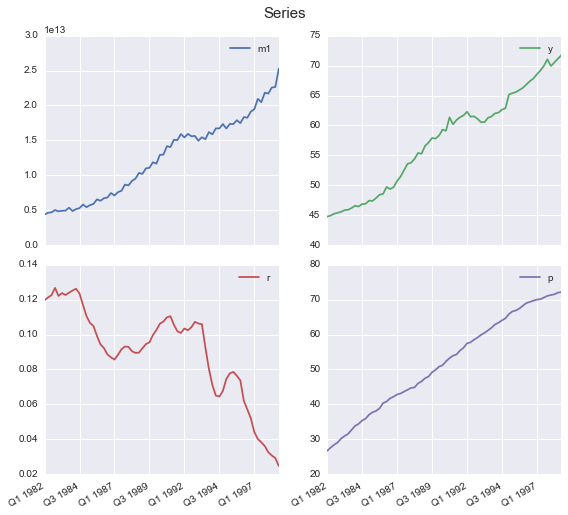

In [8]:
data = pd.concat([m1 , y, r, p], axis=1, join='inner')
data.dropna(inplace=True)
data.plot(subplots=True, layout=(2,2), figsize=(8,7))
plt.tight_layout()
plt.suptitle('Series', y=1.015, fontsize=15)
plt.savefig('imgs/series.png', bbox_inches='tight')

Los gráficos nos indican que las variables presentan tendencia determinista, excepto el caso del tipo de interés que no está muy claro. Para identificar mejor los componentes deberías hacer un contraste de dickey-fuller para todas y decidir a partir de la información recogida. A priori podemos decir que el tipo de interés tiene una tendencia mas volátil y decreciente, mientras que el resto son más estables y con tendencia creciente respecto del tiempo.

In [9]:
print(data.head())

                    m1          y         r          p
Q1 1982  4363000000000  44.744559  0.119700  26.637351
Q2 1982  4611700000000  44.912734  0.121233  27.584677
Q3 1982  4684000000000  45.216270  0.122633  28.391079
Q4 1982  5003400000000  45.375656  0.126733  29.040898
Q1 1983  4821800000000  45.541487  0.122100  30.160465


In [11]:
print(data.tail())

                     m1          y         r          p
Q4 1997  21834900000000  71.054916  0.036000  71.072951
Q1 1998  21705700000000  69.937077  0.032467  71.310435
Q2 1998  22567600000000  70.530850  0.030600  71.534871
Q3 1998  22653200000000  71.158433  0.029167  72.004619
Q4 1998  25270600000000  71.763124  0.024633  72.135105


In [12]:
data_log = np.log(data)

formula = 'np.log(m1) ~ np.log(y) + np.log(r) + np.log(p)'
results = ols(formula, data).fit()
print('$'+ formula+'$')
print('\n')
print(results.summary())

$np.log(m1) ~ np.log(y) + np.log(r) + np.log(p)$


                            OLS Regression Results                            
Dep. Variable:             np.log(m1)   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2309.
Date:                Thu, 15 Oct 2015   Prob (F-statistic):           3.80e-65
Time:                        12:28:30   Log-Likelihood:                 107.11
No. Observations:                  68   AIC:                            -206.2
Df Residuals:                      64   BIC:                            -197.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
I

A partir de la información obtenida del modelo, vemos que parece haber ausencia de autorcorrelación pero no está claro con un Durbin-Watson de 1.128 > 1, $\hat{\rho} = 1 - \frac{1.128}{2} = 0.436$ con $-1< \rho < 1$ estaríamos indecisos solo con este contraste, por lo que necesitamos más información al respecto. $H_0 = \rho = 0$

La prueba de Jarque-Bera nos da información sobre la normalidad de las perturbaciones, con un JB = 1.785 y p-value = 0.410, no podemos rechazar la normalidad de las perturbaciones. El contraste Omnibus también da evidencia a favor de la normalidad.

Nos faltaría información acerca de la correcta especificación y sobre la heterocedasticidad que calcularemos a continuación.

Tras este breve análisis, suponiendo que no hay problemas de autocorrelación, especificación y heterocedasticidad, podríamos afirmar que los t-ratios y el estadístico F siguen las distribuciones correspondientes y se puede concluir que el modelo es significativo conjuntamente, los parámetros lo son individualmente y además con un $R^2 = 0.991$ por lo que el modelo explica practicamente la totalidad del comportamiento de la variable endógena.

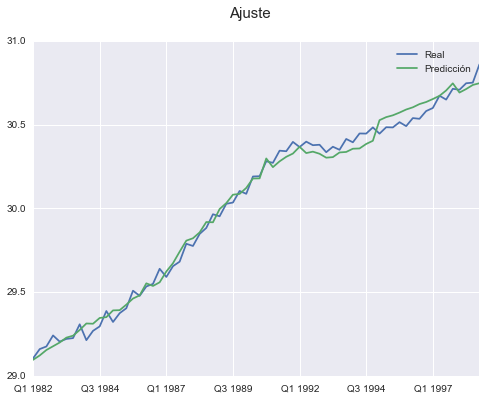

In [20]:
plt.figure(figsize=(8,6))
data_log.m1.plot(label='Real')
results.fittedvalues.plot(label='Predicción')
plt.legend()
plt.suptitle('Ajuste', fontsize=15)
plt.savefig('imgs/ols_ajuste.png', bbox_inches='tight')

En este gráfico vemos el gráfico de la endógena y la estimación de la endógena según el modelo estimado, se ve claramente que el modelo se ajusta muy bien a la realidad, aunque presenta problemas.

In [24]:
# contraste de autocorrelación de Breusch-Godfrey
print('## Contraste de Aucorrelación de Breusch-Godfrey:')
name = ['LM', 'P-value', 'F-test', 'P-value']
for i in range(1,5):
    test = sms.acorr_breush_godfrey(results, nlags=i)
    print('N=',i, ':')
    print(tb.tabulate(zip(name,test)))

## Contraste de Aucorrelación de Breusch-Godfrey:
N= 1 :
-------  ------------
LM       12.022
P-value   0.000525771
F-test   13.3277
P-value   0.000533228
-------  ------------
N= 2 :
-------  -----------
LM       23.63
P-value   7.3929e-06
F-test   16.3839
P-value   1.9393e-06
-------  -----------
N= 3 :
-------  ------------
LM       24.1781
P-value   2.29296e-05
F-test   11.1352
P-value   6.3315e-06
-------  ------------
N= 4 :
-------  ------------
LM       27.9482
P-value   1.2778e-05
F-test   10.3997
P-value   1.82468e-06
-------  ------------


Contraste LM de Breusch-Godfrey, para LM(i) con i = 1,...,4, nos dice que hay evidencia en contra de la no autocorrelación de los residuos para cada orden i. 

In [25]:
# contraste de autocorrelación de ljun-box:
print('## Contrsaste de Aucorrelación de LJung-Box')
name = 'lbvalue pvalue'.split(' ')
test = sms.acorr_ljungbox(results.resid, lags=13)
print(pd.DataFrame([test[0], test[1]], index=name).T)


## Contrsaste de Aucorrelación de LJun-Box
      lbvalue        pvalue
0   10.851982  9.869006e-04
1   29.007207  5.025336e-07
2   31.366407  7.116739e-07
3   41.047683  2.627414e-08
4   41.350204  7.971946e-08
5   41.845424  1.972617e-07
6   46.285981  7.690277e-08
7   46.286403  2.096812e-07
8   54.335390  1.629970e-08
9   55.431563  2.622770e-08
10  66.565120  5.464979e-10
11  66.925855  1.198618e-09
12  75.277305  8.451995e-11


El contraste de Ljung-Box contrasta conjuntamente la autocorrelación de orden i. La primera columna nos da el valor del LB y la segunda el p-value, que nos da evidencia en contra de la hipótesis de no autocorrelación.

Por tanto el modelo presenta problemas de autocorrelación, este problema es típico con datos de series temporales, y se puede corregir añadiendo retardos, diferenciando, conviertiendo las series en estacionarias o cambiando los datos por corte trasnversal.

In [26]:
# constraste heterocedasticidad breush-pagan
print('## Contraste de Heterocedasticidad (Breusch-Pagan):')
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(results.resid, results.model.exog)
print(tb.tabulate(list(zip(name, test))))


## Contraste de Heterocedasticidad (Breusch-Pagan):
-----------------------------  ---------
Lagrange multiplier statistic  7.90439
p-value                        0.0480296
f-value                        2.80598
f p-value                      0.0466507
-----------------------------  ---------


El contraste LM de Breusch-Pagan (BP) no informa de la presencia de homocedasticidad o ausencia de ella. Para un nivel de significación del 5% estrictamente deberíamos rechazar la hipótesis nula de homocedasticidad pero al estar tan próximo no sería sensato, necesitamos más información.

In [27]:
# constraste heterocedasticidad Golfeld-Quandt
print('## Contraste de Heterocedasticidad (Goldfeld-Quandt):')
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print(tb.tabulate(list(zip(name, test))))


## Contraste de Heterocedasticidad (Goldfeld-Quandt):
-----------  --------
F statistic  0.747412
p-value      0.785038
-----------  --------


Para buscar más información que nos permita arrojar luz sobre la homocedasticidad del modelo, nos fijamos en los resultados del contraste de Goldfeld-Quandt que nos dice que se acepta la hipótesis nula de homocedasticidad.

In [34]:
# contraste de especificacion RESET
print('## Contraste de RESET')
reset = 'm1 ~ y + r + p + y_hat2 + y_hat3'
d = data_log.copy()
d['y_hat2'] = results.predict() ** 2
d['y_hat3'] = results.predict() ** 3
res = ols(reset, d).fit()
h0 = 'y_hat2 = y_hat3 = 0'
test = res.f_test(h0)
print('Intervalo de Confianza\n')
print(res.conf_int())
print('\nF-test\n')
print(test)

## Contraste de RESET
Intervalo de Confianza

                      0            1
Intercept -12960.922679 -6033.819132
y          -5676.943123 -2641.843546
r           -191.550094   -89.157697
p           -775.389506  -360.883653
y_hat2        29.919212    64.198961
y_hat3        -0.716173    -0.334037

F-test

<F test: F=array([[ 15.96871175]]), p=2.5476772138890805e-06, df_denom=62, df_num=2>


El test de RESET contrasta la correcta especificación o no del modelo, introduciendo en el modelo original la endógena al cuadrado y al cubo si el modelo esta correctamente especificado entonces los parámetros que acompañan a las endógenas al cuadrado y al cubo deberán ser cero. En este caso vemos que el contraste reset no da evidencia en contra de la hipótesis nula, por tanto hay evidencia a favor de que el modelo está mal especificado.

In [36]:
# contraste b3=1
print('## Contraste de $\\beta_3 = 1$')
h0 = 'np.log(p) = 1'
t_test = results.t_test(h0)
print(t_test)

## Contraste de $\beta_3 = 1$
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             0.4046      0.117     -5.080      0.000         0.175     0.634


El contraste t-ratio para $\beta_3 = 1$ que se obtiene dividiendo el parámetro por su error estándar, sigue una t-student de N - k - 1 grado de libertad. Suponiendo que las muestras provienen de una población normal.

In [37]:
print('## contraste de Dickey-Fuller')
for name in data_log.columns:
    adf = sm.tsa.adfuller(data_log[name], regression='ct')[1]
    print(name, adf, int(adf < 0.05)*'***')

## contraste de Dickey-Fuller
m1 0.535720941081 
y 0.909139979336 
r 0.996444675436 
p 0.993873856301 
y_hat2 0.982420632293 
y_hat3 0.980016130055 


El contraste de dickey-fuller nos informa de si una serie tiene tendencia estocástica o no. Por lo tanto según los p-values obtenidos para cada una de las series, vemos que todas tienen tendecia estocástica y por tanto tienen memoria ilimitada. Para saber el orden de integración debemos diferenciar y voler a estimar hasta que todas sean I(0).

In [40]:
dta = data
formula = 'np.log(m1) ~ np.log(y) + np.log(r) + np.log(p)'

#results = sm.RLM(dta.m1, sm.add_constant(dta.ix[:,1:])).fit()
results = rlm(formula, dta).fit()

print('$' + formula +'$')

print(results.summary())

print('ARCH', sms.het_arch(results.resid)[1])
print('white', sms.het_white(results.resid, results.model.exog)[1])
# constraste heterocedasticidad breush-pagan
print('BP', sms.het_breushpagan(results.resid, results.model.exog)[1])
# constraste heterocedasticidad Golfeld-Quandt
print('GQ', sms.het_goldfeldquandt(results.resid, results.model.exog)[1])

$np.log(m1) ~ np.log(y) + np.log(r) + np.log(p)$
                    Robust linear Model Regression Results                    
Dep. Variable:             np.log(m1)   No. Observations:                   68
Model:                            RLM   Df Residuals:                       64
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 15 Oct 2015                                         
Time:                        14:18:58                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Int

## ¿SE CUMPLEN LOS SUPUESTO DEL MODELO LINEAL GENERAL?

### AUTOCORRELACIÓN

Para comprobar que las perturbaciones sean independientes, he aplicado los contrastes de Breusch-Godfrey y Ljun-Box, y ambos proporcionan evidencia en contra de la hipótesis nula, por tanto no aceptamos la hipótesis nula de autocorrelación.

### HOMOCEDASTICIDAD

Aplicamos los contrastes de Breusch-Pagan y Goldfeld-Quandt y encontramos contradicción entre los contrastes, pues el contraste BP nos da una evidencia muy debil en contra de la hipótesis nula, para un nivel de significación del 5% obetenemos un P-Value = 4,5%. Por otro lado el contraste Goldfeld-Quandt nos proporciona evidencia clara a favor la hipótesis nula.

Por tanto, a mi parecer existe evidencia para suponer que el modelo presenta Heterocedasticidad.

### ESPECIFICACIÓN

El contraste de RESET nos dá información acerca de la correcta especifiación del modelo, y obtenemos que hay evidencia a en contra de la hipótesis nula ($\gamma_0 = \gamma_1 = 0$), por tanto el modelo puede estar mal especificado.

### NORMALIDAD

Para validar la normalidad en las perturbaciones, aplicamos el contraste de Jarque-Vera que nos dá evidencia a favor de la normalidad.

### SIGNIFICATIVIDAD

De haberse cumplido los supuestos del MLG, los parámetros estimados se pueden interpretar y son todos significativos, tanto individual como conjuntamente.

El modelo con un $R^2 = 0.991$ explica prácticamente toda la evolución, el $\hat{R}^2 = 0.99$.

### CONTRASTE DE DICKEY-FULLER

Los p-values, del Dickey-Fuller nos dice que las series no son I(0) y por tanto las series tiene son integradas de orden 1 o más, esto evidencia tendencia estocástica cuyos shocks son permanentes, también presenta tendencia determinista. Por tanto lo que tendríamos que plantear es la primera diferencia, y comprobar nuevamente el contraste dickey-fuller.

Si se hiciera esto el contraste Dickey-Fuller nos diría que las series tampoco son I(0), salvo para el PIB. Esto nos dice que los shocks son permanentes. Si hacemos la segunda diferencia, tendremos todas las series I(0) y podríamos asegurar que son estacionarias en sentido débil.

# APARTADO A

El modelo sin logaritmos da problemas de significatividad de los parámetros. Al hacer el modelo propuesto en el enunciado, vemos que mejora considerablemente. 

Analizando paso por paso,

## El modelo planteado:

$$ log(M1) = \beta_1 log(p) + \beta_2 log(y) + \beta_3 log(rc) + u$$

Planteamos un modelo MCO para la regresión anterior y obtenemos los siguientes resultados:

### PRINCIPALES RESULTADOS

$\beta   = valor  \ (t-ratio)$

$\beta_0\ =\ 16.3003\ (0.531)$

$\beta_1\ =\ 2.96300\ (0.222)$

$\beta_2\ =\ 0.09100\ (0.024)$

$\beta_3\ =\ 0.39820\ (0.108)$

Con todos los parámetros significativos y una vez comprobado que se cumplen los supuestos del modelo lineal general (recordar que en este modelo no se cumple dado que presenta problemas de especificación y heterocedasticidad), poddríamos interpretar el modelo en términos económicos.

Si pasamos por alto los problmas del modelo vemos que estamos ante un modelo __doblemente logarítmico__ y que por tanto tenemos que interpretar los parámetros de posición como __elasticidades__, esto es, el efecto del incremento de un punto porcentual que afecta a la oferta monetaria, exceptuando el caso del tipo de interés (r) cuyas unidades son porcentajes (%) lo que dificulta su interpretación.

### EL TÉRMINO INDEPENDIENTE ($\beta_0$)

Vemos por tanto que la interpretación del término __independiente ('Intercept')__ es que si no se producen cambios en la renta, precios y el tipo de interés la oferta monetaria tiene un valor que tenemos que hallar, este valor es:

$log(M1) = \beta_0$

$e^{log(M1)} = e^{\beta_0}$

$M1 = e^{\beta_0} $

$M1 = e^{16.3003} = 11 998 593.59$

### EL EFECTO DE LA RENTA (y) EN LA OFERTA MONETARIA ($\beta_1$)

El $\beta_1 = 2.9630$ nos dice que incrementos de un 1% en la renta, tiene un efecto de 2.9630% en la oferta monetaria, casi 3 veces más intenso relativamente. Esto tiene sentido ya que por teoría sabemos que el multiplicador de la demanda de dinero tiene efecto positivo.

### EL EFECTO DEL TIPO DE INTERÉS (r) EN LA OFERTA MONETARIA ($\beta_2$)

El $ \beta_2  = 0.0910 $ nos dice que aumentos del 1% del tipo de interés(%), tiene un efecto del 0.0910% sobre la oferta de dinero. Teniendo en cuenta que para el modelo planteado la oferta monetaria es exógena, y el tipo de interés (r) es endógena, esto nos indica cómo debería cambiar la oferta monetaria para conseguir un cambio en el tipo de interés, así pues:

$ \frac{d(M)}{M} = \beta_2 d(r) $

$ \frac{1}{\beta_2} · \frac{d(M)}{M} = d(r) $

$ \frac{1}{0.0910} · \frac{d(M)}{M} = d(r) $

$ 10.989011 \frac{d(M)}{M} = d(r) $

Es importante notar que el signo del $\beta_2$ es el mismo que el $m_r$, según la teoría nos dice que $m_r < 0$ por lo tanto tenemos una __contradicción__ con la realidad. Al ser de un 0.0910 muy pequeño nos dice que la elasticidad de la oferta monetaria al tipo de interés podría ser inelástica. Esto implica que la economía podría encontrarse en una situación en la que la política monetaria deja de ser tan efectiva, en el modelo keynesiano a esto se le denomina trampa de la liquidez. Pero esta interpretación podría ser totalmente errada ya que tenemos que recordar que el modelo no cumple los supuesto básico.

### EL EFECTO DEL PRECIO SOBRE LA OFERTA MONETARIA ($\beta_3$)

El $\beta_3 = 0.3982$ nos dice que si aumentan los precios en un 1%, la oferta monetaria lo hace en un 0.3982%, es decir, que si hay inflación la oferta monetaria aumenta relativamente menos de la mitad. Esto tiene sentido con lo que nos dice la Teoría Económica, ya que:

$ \frac{M}{P} = m(r,y) $

$ log(\frac{M}{P} = log[m(r,y)] $

$ log(M) - log(P)  = log[m(r,y)] $

$ log(M) = log[m(r,y)] + log(P) $

__DERIVANDO:__

$ \frac{d(M)}{M} = \frac{m_r·d(r) + m_y · d(y)}{m(r,y)} + \frac{d(P)}{P}$ con dr, dy = 0

$ \frac{d(M)}{M} = \frac{d(P)}{P} $

Por lo tanto aumentan en la misma dirección. Importante notar que en un esquema de modelo Keynesiano o Clásico, P es una variable endógena mientras que M es exógenas, para esta última, es importante notar que las autoridades monetarias deciden M y no r como es en la realidad.

# APARTADO B
Contrastar la restricción $β_3=1$, comentando sus implicaciones económicas. 
Hacer los cálculos paso a paso sin usar las opciones directas de Gretl.

Para contrastar $\beta_3 = 1$, tenemos dos opciones, plantear un contraste F o t, dado que es más sencillo un contraste t-ratio, el procedimiento a seguir es:

## Hipótesis

$ H_0: \beta_3 = 1 $

$ H_1: \beta_3 ≠ 1 $

## Contraste

### $t = \frac{\hat{\beta_3} - \beta_3}{\sigma_{\hat{\beta_3} / \sqrt{N}}}$

### $ t = \frac{0.39820 - 1}{0.108} = -5.5722$

## Validación

### Región Critica

N = 68

n = 68 - 4

gl = 63

α = 0.05

$t < t_{(n-1 , \alpha / 2)}$

$t < t_{(63 , 0.025)}$

$ t_{(63 , 0.025)} = -1.9983 $

$ -5.722 < -1.9983 \rightarrow$ Nos indica que hay evidencia en contra de la hipótesis nula, por tanto rechazamos $H_0: \beta_3 = 1 $

In [42]:
df=len(data_log)-4-1
beta_hat = .39820
beta_h0 = 1
se = 0.108
tratio = (beta_hat - beta_h0) / se
alpha = 0.05
tscore = st.t.ppf(alpha / 2, df=df)

txt = ''' ## Contraste con los datos
Grados de Libertad = %s

$\\hat{\\beta}$ = %s

$\\beta_{H_0}$ = %s

Error Estandar = %s

t-ratio = %s

$\\alpha = %s$

punto crítico = %s''' % (df, beta_hat, beta_h0, se, tratio, alpha, tscore)

#print(txt)

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


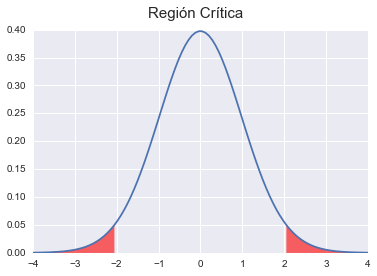

In [43]:
x = np.linspace(-4,4,100)
y = st.t.pdf(x, df=df)
plt.plot(x, y)
plt.fill_between(x=x[x<= -1.998], y1 = y[:len(x[x<= -1.998])], color = 'red', alpha=0.6)
plt.fill_between(x=x[x>= 1.998], y1 = y[-len(x[x>= 1.998]):], color='red', alpha=0.6)
plt.suptitle('Región Crítica', fontsize=15)
plt.savefig('imgs/rc.png', bbox_inches='tight')

### Contraste con los datos
Grados de Libertad = 63

$\hat{\beta}$ = 0.3982

$\beta_{H_0}$ = 1

Error Estandar = 0.108

t-ratio = -5.572222222222222

$\alpha = 0.05$

punto crítico = -1.99834054177

### P-value

$P\{t < t_{contraste}\} < \alpha $

Notar que dado que se trata de un contraste bilateral, basta compara el valor que queremos contrastar con el intervalo de confianza de $\hat{\beta}_3$, si el intervalo contiene a dicho valor entonces no se rechaza $H_0$, de lo contrario rechazaríamos la hipótesis nula.

In [45]:
txt2 = '''$P-value = P\{ t < |t-ratio|\} = %s $''' % round(st.t.cdf(tratio, df=df) * 2, 9)
print(txt2)

$P-value = P\{ t < |t-ratio|\} = 5.58e-07 $


$P-value = P\{ t < |t-ratio|\} = 5.58e-07 $

Por tanto, los tres indicadores (P-Value, Punto Crítico, Intervalo de Confianza) nos dicen que hay evidencia suficiente para rechazar la hipótesis nula o equivalentemente existe evidencia para afirmar que $\beta_3 ≠ 1$.

# APARTADO C

Estimar asumiendo que $\beta_3 = 1$, para ello tenemos que hacer unos cambios en el modelo inicial.

Modelo Inicial: 

$$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

Sustituyendo $\beta_3 = 1$:

$$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + log (ipc) + u$$

$$log (M1) - log (ipc) = β_0 + β_1 log (y) + β_2 log (r) + u$$

Esta última es la ecuación que vamos a estimar.

In [47]:
endog = data_log.m1 - data_log.p

exog = data_log.ix[:,1:-3]
exog = sm.add_constant(exog)
modelo = sm.OLS(endog, exog)
reg = modelo.fit()

endog.name = 'logM1-logP'

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             logM1-logP   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     500.5
Date:                Thu, 15 Oct 2015   Prob (F-statistic):           3.30e-40
Time:                        14:20:40   Log-Likelihood:                 93.737
No. Observations:                  68   AIC:                            -181.5
Df Residuals:                      65   BIC:                            -174.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         19.1017      0.264     72.292      0.0

In [66]:
reg.summary().tables[2]

Omnibus:,1.862,Durbin-Watson:,0.709
Prob(Omnibus):,0.394,Jarque-Bera (JB):,1.423
Skew:,0.151,Prob(JB):,0.491
Kurtosis:,2.359,Cond. No.,177.


- Según el DW parece haber presencia de autocorrelacón.
- El JB nos informa que los residuos siguen una distribución normal.
- Suponiendo cumplimiento de las hipótesis:
    - Los parámetros son significativos individualmente y conjuntamente.
    - R^2 nos dice que el modelo explica el 93.9% del comportamiento de la endógena.
- $\beta_0 (const)    19.101696$ 
- $\beta_1 (y) =         1.785015$ % que aumenta m/p por aumentos en un 1% de y.
- $\beta_2 (r) =         0.079900$ % que aumenta m/p por aumentos en un 1% de r(%).

In [37]:
reg.t_test([0,1,0])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             1.7850      0.078     23.013      0.000         1.630     1.940

In [38]:
print(reg.f_test([0,1,1]))

<F test: F=array([[ 340.05042931]]), p=1.607695553667011e-27, df_denom=65, df_num=1>


In [39]:
sm.stats.diagnostic.het_breushpagan(reg.resid, exog)

(2.6414229823727791,
 0.26694530515147258,
 1.313465666548439,
 0.27592716160620684)

In [40]:
sm.stats.diagnostic.het_arch(reg.resid)

(21.304344526097598,
 0.030351612152904713,
 2.4415894747020856,
 0.017452733153630249)

In [46]:
for i in range(1,9):
    print(i, sm.stats.diagnostic.acorr_breush_godfrey(reg, nlags=i)[:2])

1 (25.865210907232949, 3.661082569777149e-07)
2 (36.553828680309842, 1.1546143634897058e-08)
3 (37.51056548037549, 3.5879629029542688e-08)
4 (40.193943258696351, 3.9465375311716509e-08)
5 (46.059832644872969, 8.8308986282250012e-09)
6 (46.25186804555392, 2.6376564782058517e-08)
7 (46.391145107894324, 7.3360418747323098e-08)
8 (46.640610940418526, 1.7952837978300228e-07)


# APARTADO D
Suponer que queremos estimar el modelo usando la variable M1 en términos reales, imponiendo para ello la restricción del apartado b ($\beta_3 = 1$), y a la vez seguir manteniendo el ipc como variable explicativa. Pensar cómo transformar el modelo para conseguir el doble objetivo anterior y calcular de forma razonada (con la ayuda de la estimación del apartado a) el valor del coeficiente que acompaña a la variable ipc.

# ESTIMAR MLR

Una solución sería estimar el modelo lineal restringido $ \hat{\beta}_{MLR} $ con R = [0 0 1] y r = 1. 

$$ \hat{\beta}_{MLR}  = \hat{\beta}_{MCO} + (X'X)^{-1}R'[R(X'X)R']^{-1}(r-R\hat{\beta}_{MCO}) $$

16.724270
2.960928
0.099789
0.405162


$~ \left( \begin{array}{c}
16.724270 \\
2.960928 \\
0.099789 \\
0.405162 \end{array} \right) = ~ \left( \begin{array}{c}
16.724270 \\
2.960928 \\
0.099789 \\
0.404592 \end{array} \right) + ~ \left( \begin{array}{c}
0.         \\
0.         \\
0.         \\
0.00057092 \end{array} \right)$


In [55]:
x = sm.add_constant(data_log.ix[:,1:-2])
print(x.head())

         const         y         r         p
Q1 1982      1  3.800970 -2.122767  3.282314
Q2 1982      1  3.804721 -2.110038  3.317260
Q3 1982      1  3.811457 -2.098556  3.346075
Q4 1982      1  3.814976 -2.065670  3.368705
Q1 1983      1  3.818624 -2.102915  3.406532


In [56]:
xx = np.asmatrix(x.T.values) * np.asmatrix(x.values)
xx

matrix([[   68.        ,   274.79496041,  -168.22241604,   265.58354189],
        [  274.79496041,  1111.93599196,  -682.71715658,  1076.05705516],
        [ -168.22241604,  -682.71715658,   426.5699691 ,  -662.52628518],
        [  265.58354189,  1076.05705516,  -662.52628518,  1042.89294412]])

In [57]:
xx_inv = xx ** -1
xx_inv

matrix([[  8.69911019e+01,  -3.93173080e+01,  -1.53370692e+00,
           1.74400840e+01],
        [ -3.93173080e+01,   1.84260938e+01,   5.91893883e-01,
          -8.62346714e+00],
        [ -1.53370692e+00,   5.91893883e-01,   2.18678201e-01,
          -8.12204315e-02],
        [  1.74400840e+01,  -8.62346714e+00,  -8.12204315e-02,
           4.40575684e+00]])

In [59]:
R = np.asmatrix(np.array([0,0,0,1]))
r = 1
correcion = R.T * (R * xx * R.T) ** -1 * (r - R* np.asmatrix(results.params).T)
bmlr = results.params + np.asarray(correcion).flatten()
print('Corrección')
print(correcion)

Corrección
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.00057092]]


In [60]:
print('bmlr')
print(bmlr)

bmlr
Intercept    16.724270
np.log(y)     2.960928
np.log(r)     0.099789
np.log(p)     0.405162
dtype: float64


In [61]:
print(results.params)

Intercept    16.724270
np.log(y)     2.960928
np.log(r)     0.099789
np.log(p)     0.404592
dtype: float64


# APARTADO E

Estimar al modelo del apartado d) comprobando si se cumple el resultado teórico.

# GRÁFICOS ADICIONALES

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


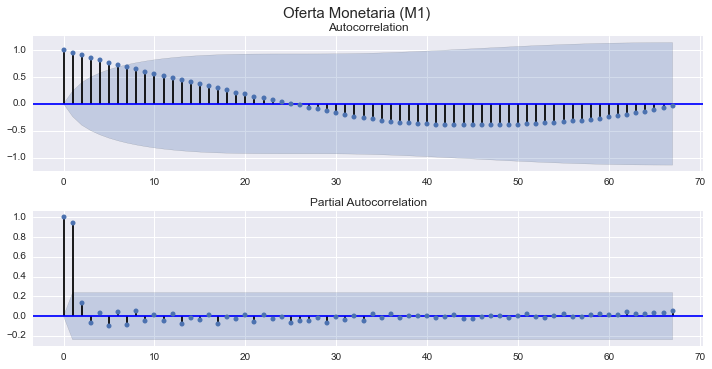

In [64]:
# desde aqui
fsize = (10,5)

plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(data.m1, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(data.m1, ax=ax2)
plt.suptitle('Oferta Monetaria (M1)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


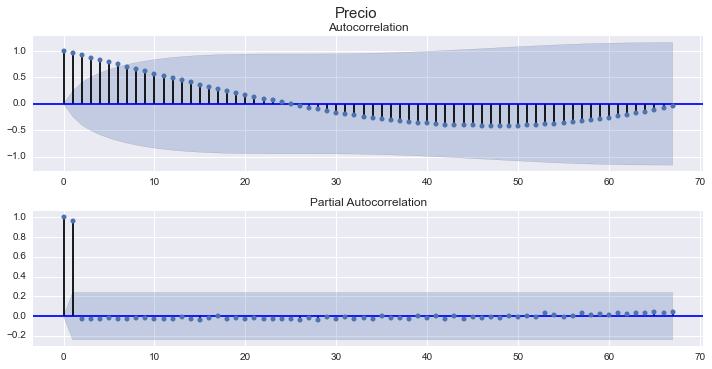

In [65]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(data.p, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(data.p, ax=ax2)
plt.suptitle('Precio', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/p_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


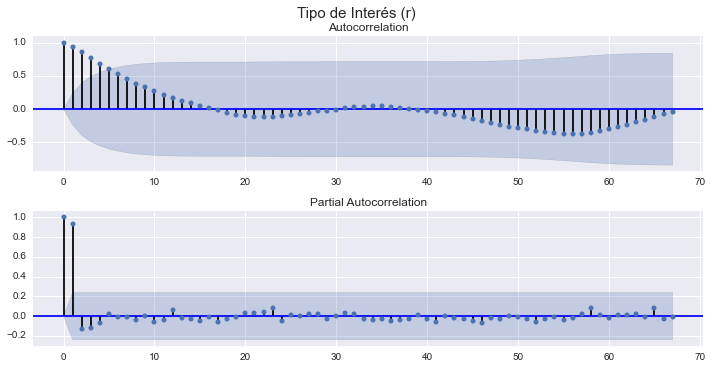

In [66]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)

plot_acf(data.r, ax=ax1)
ax2 = plt.subplot(2,1,2)

plot_pacf(data.r, ax=ax2)
plt.suptitle('Tipo de Interés (r)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/r_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


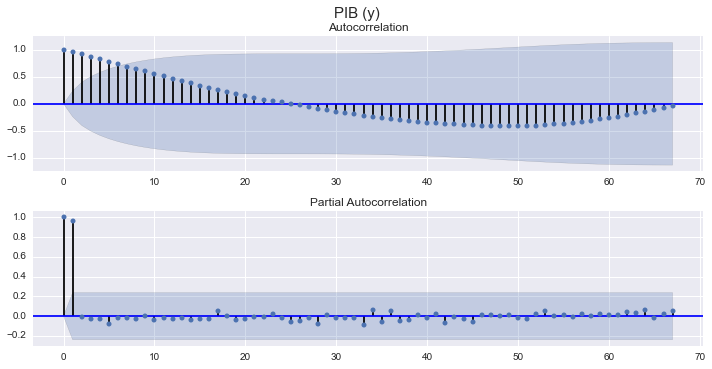

In [67]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(data.y, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(data.y, ax=ax2)
plt.suptitle('PIB (y)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/y_acor.png', bbox_inches='tight')

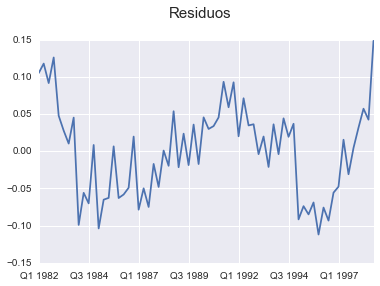

In [68]:
# residuos:
reg.resid.plot()
plt.suptitle('Residuos', fontsize=15, y=1.015)
plt.savefig('imgs/resid.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


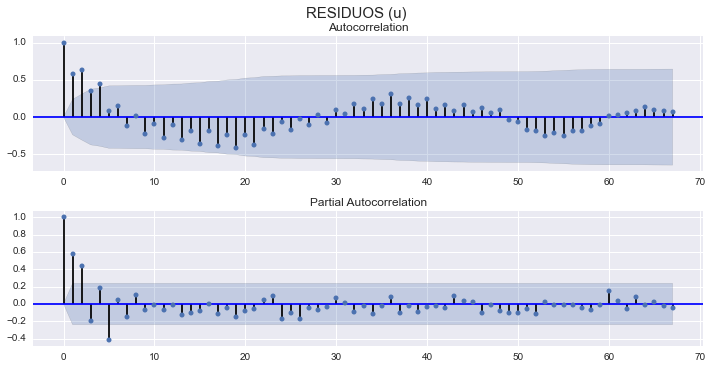

In [69]:
plt.figure(figsize=fsize)

ax1 = plt.subplot(2,1,1)
plot_acf(reg.resid, ax=ax1)

ax2 = plt.subplot(2,1,2)
plot_pacf(reg.resid, ax=ax2)

plt.suptitle('RESIDUOS (u)', fontsize=15, y=1.015)
plt.tight_layout()

plt.savefig('imgs/u_acor.png', bbox_inches='tight')